In [1]:
import numpy as np
import pandas as pd
import re, torch
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.utils.data

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
data = pd.read_pickle("data/preprocess_balanced.pkl")

Text(0.5, 1.0, 'Sequence length distribution')

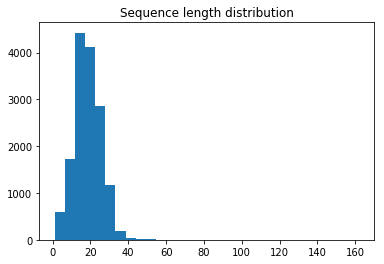

In [151]:
plt.hist([len(x) for x in data.tweet], bins=30)
plt.title("Sequence length distribution")

In [6]:
vocab_max = 50000
seq_length = 30
count_words = Counter()
for tweet in data.tweet:
    for tok in tweet:
        count_words[tok] +=1
vocab = {w for w,_ in count_words.most_common(vocab_max-2)}.union( {"UNK", "PAD"})
word2val = {w : i+2 for i, (w,_) in enumerate( count_words.most_common(vocab_max-2) )}
word2val["PAD"] = 0
word2val["UNK"] = 1
X = []
for tweet in data.tweet:
    tmp = [word2val[tok] if tok in vocab else word2val["UNK"] for tok in tweet]
    if len(tmp) > seq_length:
        X.append(tmp[:seq_length])
    else:
        X.append([0 for _ in range(seq_length - len(tmp))] + tmp)
X = np.array(X)

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, np.array(data.label), test_size=0.33, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)
X_train = torch.tensor(X_train).to(device)
X_valid = torch.tensor(X_valid).to(device)
X_test = torch.tensor(X_test).to(device)
y_train = torch.tensor(y_train).to(device)
y_valid = torch.tensor(y_valid).to(device)
y_test = torch.tensor(y_test).to(device)
train_data = torch.utils.data.TensorDataset(X_train, y_train)
valid_data = torch.utils.data.TensorDataset(X_valid, y_valid)
test_data = torch.utils.data.TensorDataset(X_test, y_test)

batch_size = 50

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [10]:
class RNN(nn.Module):
    def __init__(self,
                 emb_size,
                 hidden_size,
                 vocab_size,
                 num_layers,
                 output_size,
                 nonlinearity = 'relu',
                 bias = True,
                 dropout = 0,
                 bidirectional = False
                ):
        super(RNN, self).__init__()
        #hyper-parameters
        self.emb_size      = emb_size
        self.hidden_size   = hidden_size
        self.vocab_size    = vocab_size
        self.num_layers    = num_layers
        self.output_size   = output_size
        self.nonlinearity  = nonlinearity
        self.bias          = bias
        self.dropout       = dropout
        self.bidirectional = bidirectional
        #layers
        self.embedding = nn.Embedding(vocab_size, emb_size).to(device)
        self.rnn = nn.RNN(input_size = emb_size,
                          hidden_size = hidden_size,
                          num_layers = num_layers,
                          bias = bias,
                          dropout = dropout,
                          bidirectional = bidirectional
                         )
        self.linear = nn.Linear((bidirectional+1) *hidden_size, output_size)
        
    def forward(self, X):
        out = self.embedding(X.t())
        out, _ = self.rnn(out)
        out = self.linear(out[-1])
        return nn.functional.softmax(out, dim=-1)

In [11]:
rnn = RNN( emb_size = 100,
         hidden_size = 100,
         vocab_size = vocab_max,
         num_layers = 1,
         output_size = 4,
         bidirectional=False)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters())

In [23]:
n_epochs = 5
for epoch in range(1, n_epochs+1):
    print("Epoch: {}/{}\n".format(epoch, n_epochs))
    optimizer.zero_grad()
    running_loss = 0
    correct = 0
    for i, (X_batch, y_batch) in enumerate(train_loader):
        out = rnn.forward(X_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (torch.max(out, 1)[1] == y_batch).float().sum()
        if i%10 == 0:
            print("Samples:{}/{}\tloss: {:.4f}\tacc: {:2.3f}"\
                  .format( (i+1)*batch_size, len(train_loader.dataset),\
                          running_loss/((i+1)*batch_size), correct/((i+1)*batch_size) ), end='\r', flush=True)

Epoch: 1/5

Epoch: 2/5050/10151	loss: 0.0235	acc: 0.565



KeyboardInterrupt: 

In [19]:
(rnn(X_test[:]).max(dim=1)[1] == y_test[:]).float().sum()/len(y_test)

tensor(0.4274)